In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

import requests
import io
import os

In [42]:
kokako = pd.read_csv("observations/observations-kokako.csv")
tui = pd.read_csv("observations/observations-tui.csv")
kiwi = pd.read_csv("observations/observations-kiwi.csv")
ruru = pd.read_csv("observations/observations-ruru.csv")
kaka = pd.read_csv("observations/observations-kaka.csv")
tieke = pd.read_csv("observations/observations-tieke.csv")



In [43]:
# look at the data that was loaded in (from inaturalist observations)
print(kokako.shape)
print(tui.shape)
print(kiwi.shape)
print(ruru.shape)
print(kaka.shape)
print(tieke.shape)

(22, 39)
(513, 39)
(31, 39)
(383, 39)
(190, 39)
(59, 39)


In [44]:
# merge then shuffle
df = pd.concat([kokako, tui, kiwi, ruru, kaka, tieke])
df = df.sample(frac=1)
df.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'user_name', 'created_at',
       'updated_at', 'quality_grade', 'license', 'url', 'image_url',
       'sound_url', 'tag_list', 'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'private_place_guess', 'private_latitude',
       'private_longitude', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'positioning_method',
       'positioning_device', 'species_guess', 'scientific_name', 'common_name',
       'iconic_taxon_name', 'taxon_id'],
      dtype='object')

In [45]:
df.shape

(1198, 39)

In [46]:
df = df[["id", "sound_url", "common_name"]]
df = df.dropna()
print(df.shape)
df.head(10)

(1193, 3)


,id,sound_url,common_name
138,96194537,https://static.inaturalist.org/sounds/309511.m...,Tūī (Mainland Tūī)
330,213111990,https://static.inaturalist.org/sounds/1013997....,Ruru (Morepork)
455,211449669,https://static.inaturalist.org/sounds/1001396....,Tūī (Mainland Tūī)
251,191798750,https://static.inaturalist.org/sounds/849309.m...,Ruru (Morepork)
257,194417147,https://static.inaturalist.org/sounds/862756.m...,Ruru (Morepork)
79,105809485,https://static.inaturalist.org/sounds/351555.m...,South Island Kākā
23,9643193,https://static.inaturalist.org/sounds/17428.wa...,Ruru (Morepork)
106,70469041,https://static.inaturalist.org/sounds/168350.m...,Tūī (Mainland Tūī)
216,124960221,https://static.inaturalist.org/sounds/492063.m...,Tūī (Mainland Tūī)
108,72974258,https://static.inaturalist.org/sounds/182090.w...,Tūī (Mainland Tūī)


In [47]:
mapping = {
    "Kākā": "kaka",
    "North Island Kākā": "kaka",
    "South Island Kākā": "kaka",
    "North Island Brown Kiwi": "kiwi",
    "North Island Kōkako": "kokako",
    "Ruru (Morepork)": "ruru",
    "Tūī (Mainland Tūī)": "tui",
    "Tīeke (North Island Saddleback)": "tieke"
}


df["common_name"] = df["common_name"].map(mapping)

In [48]:
# convert the categorical data into seperate columns using one-hot encoding
df_dummies = pd.get_dummies(df, columns=['common_name'])
df_dummies.tail()

,id,sound_url,common_name_kaka,common_name_kiwi,common_name_kokako,common_name_ruru,common_name_tieke,common_name_tui
130,96980331,https://static.inaturalist.org/sounds/312246.m...,False,False,False,True,False,False
42,26480411,https://static.inaturalist.org/sounds/40685.mp...,False,False,False,True,False,False
365,244284153,https://static.inaturalist.org/sounds/1213155....,False,False,False,True,False,False
134,95509612,https://static.inaturalist.org/sounds/307576.m...,False,False,False,False,False,True
78,48989370,https://static.inaturalist.org/sounds/104796.m...,False,False,False,True,False,False


In [49]:
# Now download the audio files

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

for row in df.itertuples():
    try:
        url = row["sound_url"]
        file_name = str(row.id) + ".mp3"
        file_path = os.path.join(output_dir, file_name)
        
        print(f"Downloading {url}...")
        
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes
        
        # Save the file locally
        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        print(f"Saved: {file_path}")
    
    except Exception as e:
        print(f"Failed to download {url}: {e}")

Saved: data\96194537.mp3
Saved: data\213111990.mp3
Saved: data\211449669.mp3
Saved: data\191798750.mp3
Saved: data\194417147.mp3
Saved: data\105809485.mp3
Saved: data\9643193.mp3
Saved: data\70469041.mp3
Saved: data\124960221.mp3
Saved: data\72974258.mp3
Saved: data\78209185.mp3
Saved: data\233046790.mp3
Saved: data\150428530.mp3
Saved: data\36583480.mp3
Saved: data\181119742.mp3
Saved: data\146304283.mp3
Saved: data\67171053.mp3
Saved: data\158996948.mp3
Saved: data\196101581.mp3
Saved: data\105804518.mp3
Saved: data\175843031.mp3
Saved: data\152444162.mp3
Saved: data\11147408.mp3
Saved: data\206902476.mp3
Saved: data\126049758.mp3
Saved: data\89170812.mp3
Saved: data\35482105.mp3
Saved: data\109005590.mp3
Saved: data\108350678.mp3
Saved: data\249731421.mp3
Saved: data\192790470.mp3
Saved: data\92863988.mp3
Saved: data\29232300.mp3
Saved: data\189741528.mp3
Saved: data\227342799.mp3
Saved: data\75721185.mp3
Saved: data\103538653.mp3
Saved: data\95727874.mp3
Saved: data\96930599.mp3
Sa

In [50]:
df.to_parquet("birds.parquet")

In [17]:
def load_audio(url):
    """
        Using the url, get the audio data using librosa
    """
    #url = df_dummies['sound_url'].iloc[1]

    response = requests.get(url)

    if response.status_code == 200:

        audio_bytes = io.BytesIO(response.content)
        y, sr = librosa.load(audio_bytes, sr=None)

        y_trimmed, _ = librosa.effects.trim(y)

        return y_trimmed, sr
        

    else:
        print("Response: ", response)
        return None

In [18]:
print(df_dummies["sound_url"])

95     https://static.inaturalist.org/sounds/472696.m...
289    https://static.inaturalist.org/sounds/587242.m...
6      https://static.inaturalist.org/sounds/12454.mp...
124    https://static.inaturalist.org/sounds/268379.m...
192    https://static.inaturalist.org/sounds/584517.m...
                             ...                        
106    https://static.inaturalist.org/sounds/168350.m...
12     https://static.inaturalist.org/sounds/15262.wa...
159    https://static.inaturalist.org/sounds/406571.m...
109    https://static.inaturalist.org/sounds/184201.m...
393    https://static.inaturalist.org/sounds/839453.m...
Name: sound_url, Length: 1198, dtype: object


In [19]:
url = df_dummies['sound_url'].iloc[0]

y, sr = load_audio(url)

LibsndfileError: Error opening <_io.BytesIO object at 0x000001F15E802750>: Format not recognised.

<Axes: >

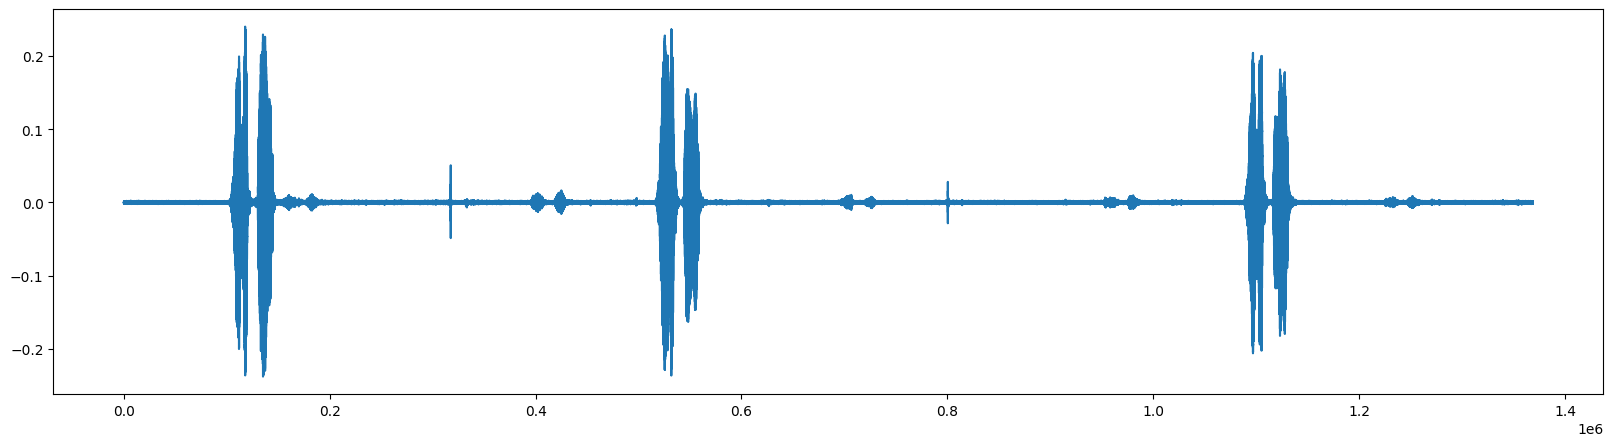

In [15]:
pd.Series(y).plot(figsize=(20, 5))

<Axes: >

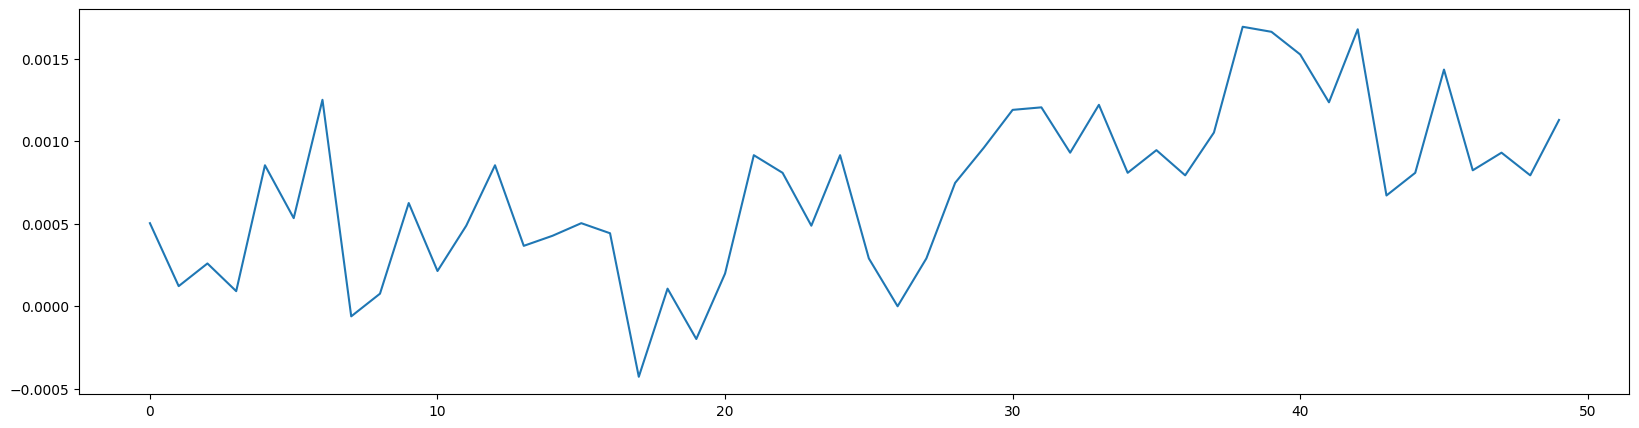

In [16]:
pd.Series(y[55000:55050]).plot(figsize=(20, 5))

### Forier transform on the data to get the frequencies (spectogram)

In [81]:
D = librosa.stft(y)

S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

S_db.shape

(1025, 3380)

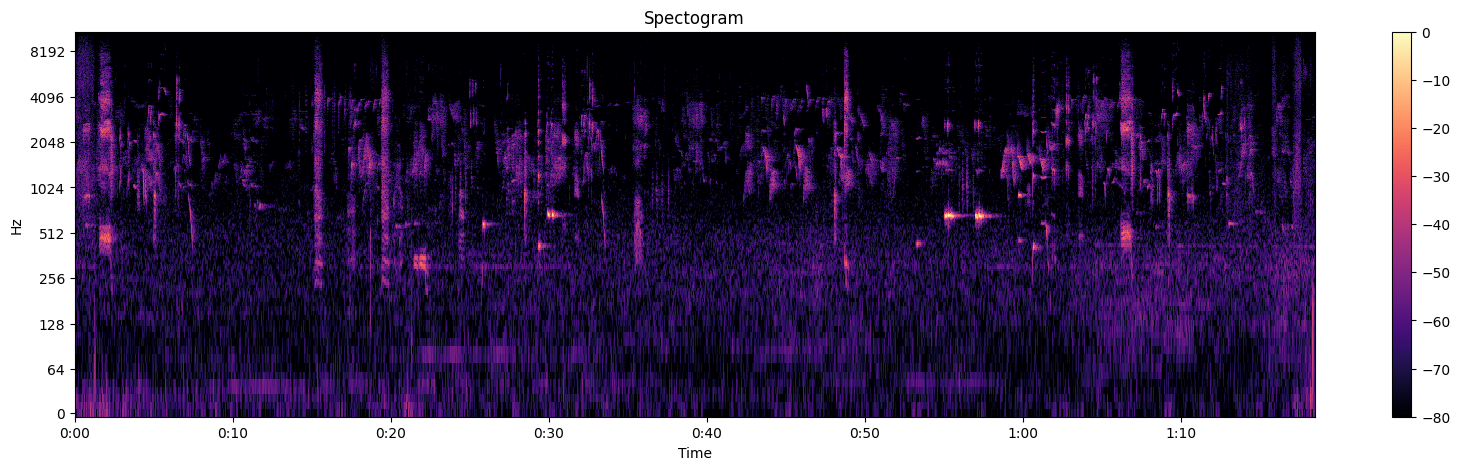

In [82]:
# plot transformed data
fig, ax = plt.subplots(figsize=(20, 5))
img = librosa.display.specshow(S_db, x_axis="time", y_axis='log', ax=ax)
ax.set_title("Spectogram")
fig.colorbar(img, ax=ax)

### MELL spectogram

In [83]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

S_db.shape

(128, 3380)

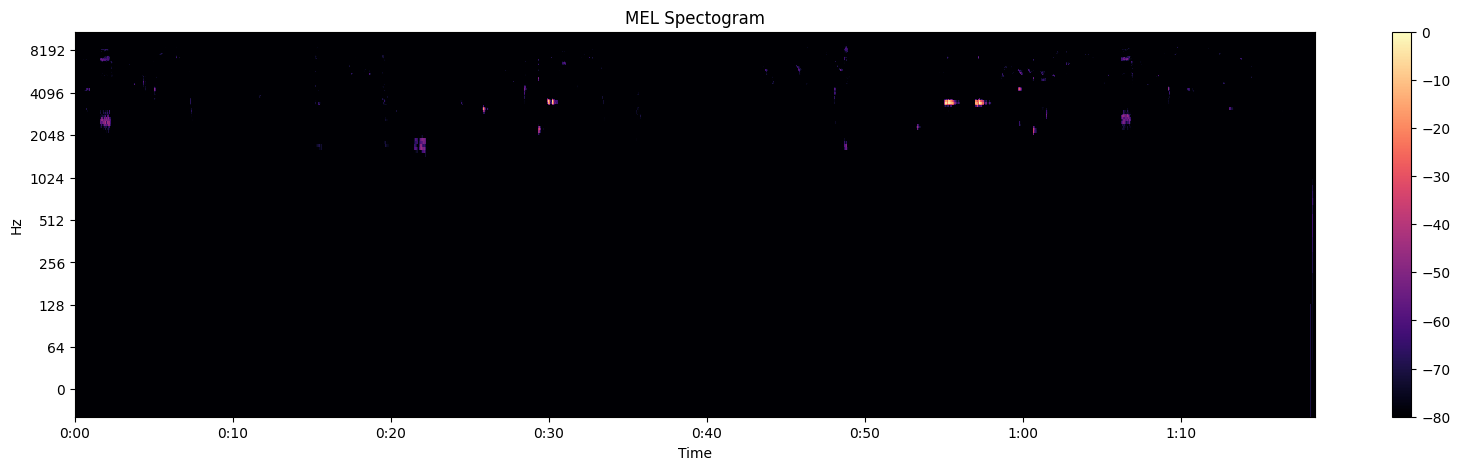

In [84]:
# plot transformed data
fig, ax = plt.subplots(figsize=(20, 5))
img = librosa.display.specshow(S_db, x_axis="time", y_axis='log', ax=ax)
ax.set_title("MEL Spectogram")
fig.colorbar(img, ax=ax)